### This notebook compares outcomes based on scores obtained using combinations of two connectivity measures. 

In [1]:
conn_measures = ["PAC",
                 "SCR-(0,4)","SCR-(4,8)","SCR-(8,13)","SCR-(13,30)","SCR-(30,70)","SCR-(70,150)",
                "SCI-(0,4)","SCI-(4,8)","SCI-(8,13)","SCI-(13,30)","SCI-(30,70)","SCI-(70,150)",
                "PLV-(0,4)","PLV-(4,8)","PLV-(8,13)","PLV-(13,30)","PLV-(30,70)","PLV-(70,150)",
                "PLI-(0,4)", "PLI-(4,8)", "PLI-(8,13)", "PLI-(13,30)", "PLI-(30,70)", "PLI-(70,150)", 
                "CC-(0,4)","CC-(4,8)","CC-(8,13)","CC-(13,30)","CC-(30,70)","CC-(70,150)"] 

In [2]:
import pandas as pd
from pickle import load, dump
import numpy as np

In [3]:
# function to map all values >=threshold to 1 and all values <threshold to 0
def to_labels(pos_probs, threshold):
	return list((pos_probs >= threshold).astype('int')) 

def moving_thresh_auc(predictive_measure=[], outcome=[], moving_step=0.00001):

    thresholds = np.arange(0, np.max(predictive_measure), moving_step)

    g = np.array([pm for i,pm in enumerate(predictive_measure) if outcome[i]=="good"])
    b = np.array([pm for i,pm in enumerate(predictive_measure) if outcome[i]=="bad"])

    A, A_top = 0, 0
    T = 0
    tp_top, tn_top = 0, 0
    step = 0
    for t in thresholds:    
        g_l, b_l = to_labels(g, t), to_labels(b, t)
        tp = sum(g_l)/14 
        tn = b_l.count(0)/7
        A = (tp + tn)/2
        if A>A_top: 
            step=0
            A_top=A
            T=t
            tn_top,tp_top=tn,tp
        elif A==A_top: step+=moving_step

    return (A_top, T, tn_top, tp_top)

#### The code below computes Welch t-test or MannWhitneyU double-sided test with Bonferroni correction, depending on if the scores are distibuted normally or not, respectively.
#### Plot only the statistically significant differences.
#### Compute AUC using a moving threshold.

In [4]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# main_folder = "/content/gdrive/My Drive/epigame-folder/"

main_folder = "/home/kivi/gdrive/epigame-folder/"

path_res = main_folder + "cvs_pairs/"

path_deck = main_folder + "decks/"
path_scores = main_folder + "game_scores/"

woi = "preseizure1"

t-test_welch


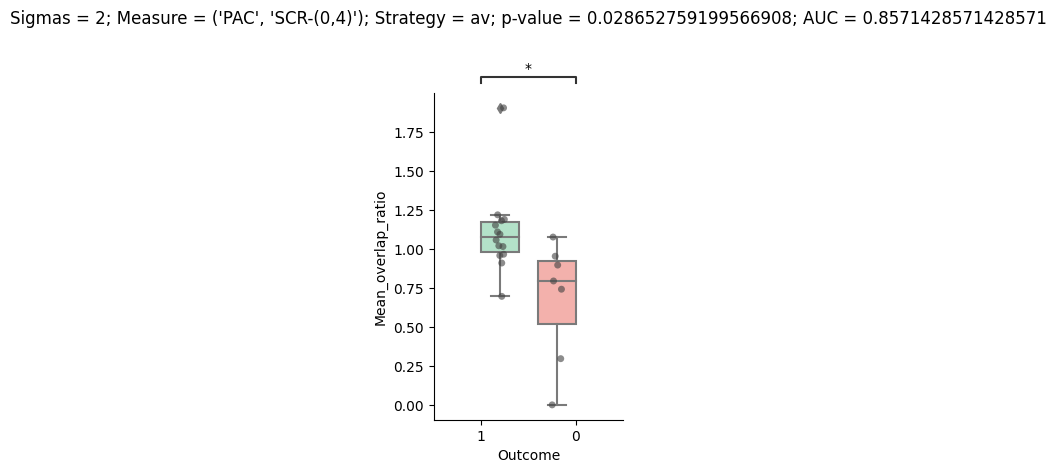

t-test_welch


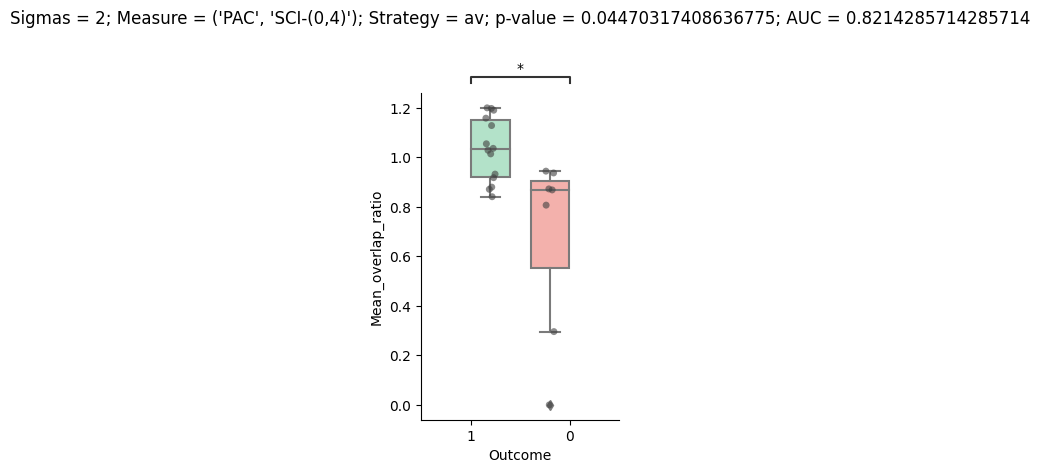

Mann-Whitney


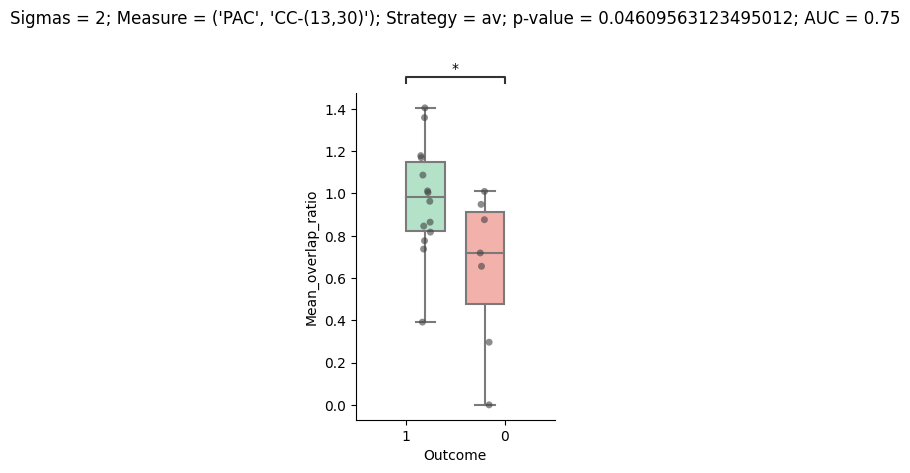

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from statannot import add_stat_annotation

from scipy.stats import shapiro
from itertools import combinations

# Do not print out pyplot outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"

Sigmas, CM, Strategy, Gauss, Pvalue_Shapiro, Test, Pvalue, MAUC, T, TN, TP = [],[],[],[],[],[],[],[],[],[],[]

for sigmas in [2,3,4]:

    load_data = pd.read_excel(main_folder+f"surgical_outcome_data_{sigmas}sigma.xlsx", engine='openpyxl')

    strategies = ["mm", "mx", "av", "rn"]

    load_data["Mean_overlap_ratio"].fillna(0, inplace=True) # if 0 winners, nan is saved, so replace it with 0

    conn_combinations = combinations(conn_measures, 2) # measure pairs

    for cm1,cm2 in conn_combinations:

        for strategy in strategies:
            data1 = load_data.groupby("CM").get_group(cm1).groupby("Strategy").get_group(strategy)
            data2 = load_data.groupby("CM").get_group(cm2).groupby("Strategy").get_group(strategy)

            # the combination is made as a mean value between two scores
            x_plot = [np.mean([val, list(data2.Mean_overlap_ratio)[i]]) for i,val in enumerate(data1.Mean_overlap_ratio)]
            y_plot = ["good" if val==1 else "bad" for val in data1["Outcome"]]

            data = data1
            data.Mean_overlap_ratio = x_plot

            # calculate moving threshold-based AUC
            mauc = moving_thresh_auc(x_plot, y_plot, moving_step=0.00001)

            gaussian, stest = False, ''
            stat, p = shapiro(x_plot)
            if p > 0.05: stest = 'Mann-Whitney'; gaussian = True
            else: stest = 't-test_welch'

            g = sns.catplot(data=data, x='Outcome', y='Mean_overlap_ratio', order=[1,0], kind="box", hue="Outcome",
                            palette=["#FFA7A0", "#ABEAC9"],
                            height=4, aspect=.7);
            g.map_dataframe(sns.stripplot, x='Outcome', y='Mean_overlap_ratio', order=[1,0], hue="Outcome",
                            palette=["#404040","#404040"],
                            alpha=0.6, dodge=True);

            p_annot = add_stat_annotation(g.axes[0][0], data=data, x=x_plot, y=y_plot, order=["good","bad"],
                            box_pairs=[("good","bad")],
                            test=stest, text_format='star', loc='outside', verbose=0);
            
            pvalue = p_annot[1][0].__dict__["pval"]
            if pvalue<=0.05:
                print(stest)
                plt.title(f"Sigmas = {sigmas}; Measure = {cm1,cm2}; Strategy = {strategy}; p-value = {pvalue}; AUC = {mauc[0]}", pad=50)
                plt.show()

            plt.close('all')

            Sigmas.append(sigmas)
            CM.append((cm1,cm2))
            Strategy.append(strategy)
            Gauss.append(gaussian)
            Pvalue_Shapiro.append(p)
            Test.append(stest)
            Pvalue.append(pvalue)
            MAUC.append(mauc[0])
            T.append(mauc[1])
            TN.append(mauc[2])
            TP.append(mauc[3])

outcome_mannwhitneyu = pd.DataFrame({"CM":CM, "Strategy":Strategy, "Sigmas":Sigmas,
                                     "Gauss":Gauss, "Pvalue-Shapiro":Pvalue_Shapiro,
                                     "Test":Test, "Pvalue":Pvalue,
                                     "MAUC":MAUC, "T":T, "TN":TN, "TP":TP})
outcome_mannwhitneyu.to_excel(main_folder+f"surgical_outcome_prediction_combinations.xlsx")
pass;